In [1]:
# This cell comes from starting a new Kaggle notebook

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# This prints all of the file names in the input directory
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# This is needed if attempting to use TPU in Kaggle's environment
#!pip install seaborn

In [3]:
# CITATION: this cell is a part of the following notebook, that I slightly changed:
#
# Thite, S. (2023, October 9). UBC ovarian cancer subtype classification-CNN. Kaggle. 
# https://www.kaggle.com/code/sunilthite/ubc-ovarian-cancer-subtype-classification-cnn/notebook

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 

In [4]:
# If wanting to use a TPU
# CITATION: this code is from:
# Holbrook, R. (2020, September 24). Getting started with tpus. Kaggle. 
# https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus 
"""
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
"""

"\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() \n    print('Running on TPU ', tpu.master())\nexcept ValueError:\n    tpu = None\n"

In [5]:
# If wanting to use a TPU
# CITATION: this code is from:
# Holbrook, R. (2020, September 24). Getting started with tpus. Kaggle. 
# https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus 
"""
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
"""

'\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    strategy = tf.distribute.get_strategy() \n'

**Data loading and preprocessing**

CITATION: this section of the notebook is a part of the following notebook, that I slightly changed:

Thite, S. (2023, October 9). UBC ovarian cancer subtype classification-CNN. Kaggle. 
https://www.kaggle.com/code/sunilthite/ubc-ovarian-cancer-subtype-classification-cnn/notebook


In [6]:
train_df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")

In [7]:
# The paths for the medical images
path_train = "/kaggle/input/UBC-OCEAN/train_images"
path_test = "/kaggle/input/UBC-OCEAN/test_images"
train_folder = os.listdir(path_train)
test_folder = os.listdir(path_test)

In [8]:
# The paths for the thumbnail images
path_train_copy = "/kaggle/input/UBC-OCEAN/train_thumbnails"
path_test_copy = "/kaggle/input/UBC-OCEAN/test_thumbnails"
train_folder_copy = os.listdir(path_train_copy)
test_folder_copy = os.listdir(path_test_copy)

print(len(train_folder_copy))
print(len(test_folder_copy))

513
1


In [9]:
train_df_tma = train_df[train_df['is_tma']==True]

In [10]:
train_df_no_tma = train_df[train_df['is_tma']==False]

In [11]:
train_df_no_tma['image_id_path'] = [f"{i}_thumbnail.png" for i in train_df_no_tma['image_id']]

In [12]:
train_df_tma['image_id_path'] = [f"{i}.png" for i in train_df_tma['image_id']]

In [13]:
train_thumbnails_folder = train_folder_copy

In [14]:
# This cell is to calculate class weights to account for the class imbalance in this dataset
# The next cell is to print these class weight
#CITATION: this code is from the following notebook:
# Gosthipaty, A. R. (2023, October 17). [KERASCV] train and infer on thumbnails. Kaggle. 
# https://www.kaggle.com/code/aritrag/kerascv-train-and-infer-on-thumbnails/notebook 

# Perform one-hot encoding of the 'label' column and explicitly convert to integer type
df_one_hot = pd.get_dummies(train_df["label"], prefix="label").astype(int)

# Concatenate the original DataFrame with the one-hot encoded labels
weights_df = pd.concat([train_df["image_id"], df_one_hot], axis=1)

labels = weights_df[[col for col in weights_df.columns if col.startswith("label_")]].values
class_weights = np.sum(labels) - np.sum(labels, axis=0)
class_weights = class_weights / np.sum(class_weights) # Normalize the weights

class_weights = {idx:weight for idx, weight in enumerate(class_weights)}

In [15]:
print(class_weights)

{0: 0.20399628252788105, 1: 0.19237918215613384, 2: 0.14684014869888476, 3: 0.22815985130111524, 4: 0.22862453531598512}


In [16]:
image_data = []
image_label = []
path = "/kaggle/input/UBC-OCEAN/train_thumbnails"
path1="/kaggle/input/UBC-OCEAN/train_images/"
for img , label in zip(train_df_no_tma['image_id_path'],train_df_no_tma['label']):
    image = Image.open("/kaggle/input/UBC-OCEAN/train_thumbnails/"+img)
    image = image.resize((256,256))
    image = image.convert("RGB")
    image = np.array(image)
    image_data.append(image)
    image_label.append(label)

for img , label in zip(train_df_tma['image_id_path'],train_df_tma['label']):
    image = Image.open("/kaggle/input/UBC-OCEAN/train_images/"+img)
    image = image.resize((256,256))
    image = image.convert("RGB")
    image = np.array(image)
    image_data.append(image)
    image_label.append(label)

In [17]:
set(image_label)

{'CC', 'EC', 'HGSC', 'LGSC', 'MC'}

In [18]:
image_label_1 = []
for i in image_label:
    if i=="CC":
        image_label_1.append(0)
    elif i=="EC":
        image_label_1.append(1)
    elif i=="HGSC":
        image_label_1.append(2)
    elif i=="LGSC":
        image_label_1.append(3)
    elif i=="MC":
        image_label_1.append(4)

In [19]:
x = np.array(image_data)
y = np.array(image_label_1)

In [20]:
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,shuffle=True)

In [21]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

In [22]:
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,shuffle=True)

In [23]:
# This is my addition
# In some runs, I would delete some of the arrays that are no longer needed
# This is to save space in the Kaggle environment as it is limited
import gc
del x
del y
del image_data
del image_label_1
del image_label
del train_df
del train_df_tma
del train_df_no_tma
gc.collect()

0

**Experiments**

This section is mostly my code

In [24]:
# This is the function I wrote the creates a model of the second architecture with the given hyperparameter values
# The second architecture is a CNN with two convolutional layer followed my a max pooling layer, potentially repeated multiple times,
# Determinted by the num_units input
# The CNN is then connected to an MLP
def getModelSecond(model, num_units):
    if num_units == 1:
        model.add(Conv2D(filters=200,kernel_size=(3,3),strides=(1,1),activation='relu',input_shape=(256,256,3)))
        model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
    else:
        model.add(Conv2D(filters=200,kernel_size=(3,3),strides=(1,1),activation='relu',input_shape=(256,256,3)))
        model.add(Conv2D(filters=190,kernel_size=(3,3),strides=(1,1),activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
      
        for i in range(num_units - 1):
            model.add(Conv2D(filters=200 - int(136/(num_units - 1 - i)),kernel_size=(3,3),strides=(1,1),activation='relu'))
            model.add(Conv2D(filters=190 - int(136/(num_units - 1 - i)),kernel_size=(3,3),strides=(1,1),activation='relu'))
            model.add(MaxPooling2D(pool_size=(2,2)))
                             
    model.add(Flatten())
    model.add(Dense(units=512,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=5,activation='softmax'))
    
    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

In [25]:
# This is to utilize the TPU
# The next two lines after this one need to be indented to use this
# This is from the citation for the TPU usage at the beginning of this notebook
# with strategy.scope():    model = Sequential()
num_units = 1
num_epochs = 10

model = Sequential()
getModelSecond(model, num_units)

# Fit data to model
# I use the class weights here
history = model.fit(x_train_scaled, y_train,
            batch_size=16,
            epochs=num_epochs,
            class_weight=class_weights)

Epoch 1/10
29/29 [==============================] - 18s 208ms/step - loss: 18.7304 - accuracy: 0.2560
Epoch 2/10
29/29 [==============================] - 4s 131ms/step - loss: 13.7573 - accuracy: 0.2954
Epoch 3/10
29/29 [==============================] - 4s 131ms/step - loss: 5.1556 - accuracy: 0.2670
Epoch 4/10
29/29 [==============================] - 4s 131ms/step - loss: 1.5228 - accuracy: 0.2210
Epoch 5/10
29/29 [==============================] - 4s 131ms/step - loss: 0.3093 - accuracy: 0.3895
Epoch 6/10
29/29 [==============================] - 4s 130ms/step - loss: 0.2907 - accuracy: 0.4201
Epoch 7/10
29/29 [==============================] - 4s 130ms/step - loss: 0.2859 - accuracy: 0.4136
Epoch 8/10
29/29 [==============================] - 4s 131ms/step - loss: 0.2849 - accuracy: 0.4158
Epoch 9/10
29/29 [==============================] - 4s 131ms/step - loss: 0.2822 - accuracy: 0.4158
Epoch 10/10
29/29 [==============================] - 4s 131ms/step - loss: 0.2820 - accuracy: 0.4

**Model evaluation**

I used the train/test split from the beginnig of the notebook for this.

CITATION: this section of the notebook is from two notebooks:
Thite, S. (2023, October 9). UBC ovarian cancer subtype classification-CNN. Kaggle. https://www.kaggle.com/code/sunilthite/ubc-ovarian-cancer-subtype-classification-cnn/notebook 

and:
Pazze, J. S. (2023, October 9). Eda + baseline. Kaggle. https://www.kaggle.com/code/jefersonpazze/eda-baseline 

In [26]:
loss, acc = model.evaluate(x_test_scaled,y_test)
print("Accuracy on Test Data:",acc)
print()
loss, acc = model.evaluate(x_train_scaled,y_train)
print("Accuracy on Train Data:",acc)

3/3 [==============================] - 3s 422ms/step - loss: 1.5319 - accuracy: 0.4074
Accuracy on Test Data: 0.40740740299224854

15/15 [==============================] - 1s 55ms/step - loss: 1.5086 - accuracy: 0.4158
Accuracy on Train Data: 0.41575491428375244


dict_keys(['loss', 'accuracy'])


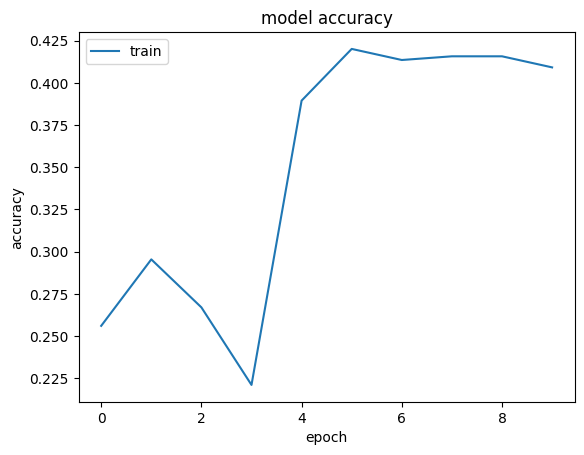

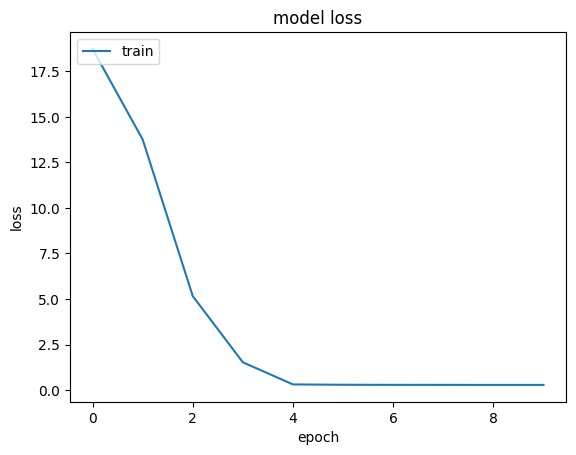

In [27]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()